In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime
import seaborn as sns
sns.set_theme()


In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)
    # Return entry [0,1]
    return corr_mat[0,1]
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
    return bs_replicates

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [3]:
finch1975 = pd.read_csv('finch_beaks_1975.csv') ; finch2012 = pd.read_csv('finch_beaks_2012.csv')
finch1975.columns=['band','species','blength','bdepth']
finch1975['year']=1975 ; finch2012['year']=2012
finches = pd.concat([finch1975, finch2012], ignore_index=True)
finches.columns=['band','species','beak_length','beak_depth','year']
df= finches[finches['species']=='scandens'].reset_index()
bd_1975 = finch1975[finch1975['species'] =='scandens'] ; bd_1975 = bd_1975.iloc[:,3].values
bd_2012 = finch2012[finch2012['species'] =='scandens'] ; bd_2012 = bd_2012.iloc[:,3].values
bl_1975 = finch1975[finch1975['species'] =='scandens'] ; bl_1975 = bl_1975.iloc[:,2].values
bl_2012 = finch2012[finch2012['species'] =='scandens'] ; bl_2012 = bl_2012.iloc[:,2].values

In [4]:
finches

,band,species,beak_length,beak_depth,year
0,2,fortis,9.4,8.0,1975
1,9,fortis,9.2,8.3,1975
2,12,fortis,9.5,7.5,1975
3,15,fortis,9.5,8.0,1975
4,305,fortis,11.5,9.9,1975
...,...,...,...,...,...
646,21295,scandens,14.2,9.3,2012
647,21297,scandens,13.0,9.8,2012
648,21340,scandens,14.6,8.9,2012
649,21342,scandens,13.1,9.8,2012


# 1. Finch beaks and the need for statistics
You are now carrying a well-stocked toolbox.

2. Your well-equipped toolbox
You know how to take a data set and explore it. You know how to think probabilistically and infer values and confidence intervals for parameters. And you know how to formulate a hypothesis and use your data, and Python, to test it. Let's put those tools to use! In this chapter, you will immerse yourself in what is in my opinion one of the most fascinating data sets out there. You may know that many of the important observations that

3. Image: Public domain, US
led Charles Darwin to develop the theory of evolution were made

1 Image: Public domain, US
4. Image: NASA
in the Galápagos archipelago, particularly in the study of the small birds, called finches, that inhabit them. The islands are ideal for studying evolution because they are isolated so they do not have complicated effects from interactions with other species including humans. Furthermore, some of them are small, so entire populations can be monitored on a given island. Every year since 1973, Peter and Rosemary Grant of Princeton University have been spending several months of the year on

1 Image: NASA
5. The island of Daphne Major
the tiny volcanic cinder cone island of Daphne Major in the Galápagos.

1 Image: Grant and Grant, 2014
6. The finches of Daphne Major
This island has two dominant ground finch species, Geospiza fortis and Geospiza scandens. The Grants have monitored them every year, tagging them, making physiological measurements, taking samples for genetic sequencing, and more. In 2014,

1 Source: John Gould, public domain
7. Our data source
they published a book entitled "40 Years of Evolution: Darwin's Finches on Daphne Major Island". They generously placed all of their data on the Dryad data repository making it free for anyone to use. The data set is impressive and a great set for using data science and statistical inference to learn about evolution. You will work with the Grants' measurements of

8. The dimensions of the finch beak
the beak length and

1 Source: John Gould, public domain
9. The dimensions of the finch beak
beak depth. You will consider different aspects of the beak geometry, including how it varies over time, from species to species, and from parents to offspring. I will come back with short discussions as you are working through the data sets, but you are mostly on your own. You can do it! Ok, for your first analysis,

1 Source: John Gould, public domain
10. Investigation of G. scandens beak depth
you will investigate how the beak depth of Geospiza scandens has changed over time. You will start with some exploratory analysis of the measurements of these species from 1975 and 2012. You will then perform a parameter estimation, with confidence intervals, of mean beak depth for those respective years. Finally, you will do a hypothesis test investigating if the mean beak depth has changed from 1975 to 2012.

11. Let's practice!
Have at it!

# EDA of beak depths of Darwin's finches
For your first foray into the Darwin finch data, you will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

In the next few problems, you will look at the beak depth of G. scandens on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

The data are stored in a pandas DataFrame called df with columns 'year' and 'beak_depth'. The units of beak depth are millimeters (mm).

Instructions
100 XP
Create the beeswarm plot.
Label the axes.
Show the plot.

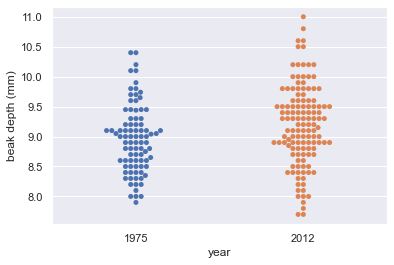

In [5]:
# Create bee swarm plot
_ = sns.swarmplot(x='year',y='beak_depth',data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

#### It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

# ECDFs of beak depths
While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.

For your convenience, the beak depths for the respective years has been stored in the NumPy arrays bd_1975 and bd_2012.

Instructions
70 XP
Compute the ECDF for the 1975 and 2012 data.
Plot the two ECDFs.
Set a 2% margin and add axis labels and a legend to the plot.
Hit submit to view the plot!


Show Answer (-70 XP)
Hint
Use the ecdf() function to compute the ECDF for bd_1975 and bd_2012.
Plot the x and y values you generated from the ecdf() function by passing them in as arguments to plt.plot().
You can set the correct margin using plt.margins(). The axis labels can be added with plt.xlabel() and plt.ylabel(), while the legend can be added with plt.legend.

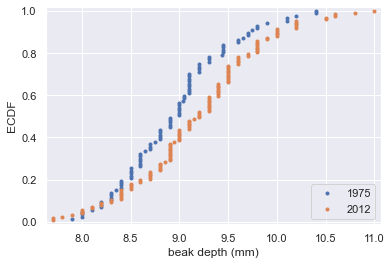

In [6]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012,y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

# Parameter estimates of beak depths
Estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.

Since in this exercise you will use the draw_bs_reps() function you wrote in chapter 2, it may be helpful to refer back to it.

Instructions
70 XP
Compute the difference of the sample means.
Take 10,000 bootstrap replicates of the mean for the 1975 beak depths using your draw_bs_reps() function. Also get 10,000 bootstrap replicates of the mean for the 2012 beak depths.
Subtract the 1975 replicates from the 2012 replicates to get bootstrap replicates of the difference of means.
Use the replicates to compute the 95% confidence interval.
Hit submit to view the results!


Show Answer (-70 XP)
Hint
Use np.mean() to calculate the sample means of bd_1975 and bd_2012, and store the difference between them in mean_diff.
Use the draw_bs_reps() function with np.mean as the func argument to generate 10,000 bootstrap replicates of bd_1975 and bd_2012.
To get the bootstrap replicates of the difference of means, compute the difference between bs_replicates_2012 and bs_replicates_1975.
Recall that you can use np.percentile() to calculate confidence intervals. For a 95% confidence interval, you would pass in the 2.5th and 97.5th percentiles in the form of a list as an argument to np.percentile().
The print statements have already been written for you, so just hit submit after computing the 95% confidence interval.

In [7]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06339972 0.39124923] mm


# Hypothesis test: Are beaks deeper in 2012?
Your plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

Be careful! The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

Instructions
100 XP
Make a concatenated array of the 1975 and 2012 beak depths and compute and store its mean.
Shift bd_1975 and bd_2012 such that their means are equal to the one you just computed for the combined data set.
Take 10,000 bootstrap replicates of the mean each for the 1975 and 2012 beak depths.
Subtract the 1975 replicates from the 2012 replicates to get bootstrap replicates of the difference.
Compute and print the p-value. The observed difference in means you computed in the last exercise is still in your namespace as mean_diff.

First concatenate bd_1975 and bd_2012 with np.concatenate(), and then take the mean of this concatenated array with np.mean().
To shift bd_1975 and bd_2012 as described in the instructions, you should subtract their individual means from themselves and add the combined_mean you calculated above.
Since you need the bootstrap replicates of the mean, the argument to the func parameter of draw_bs_reps() should be np.mean.
To get bootstrap replicates of the difference, compute the difference between bs_replicates_2012 and bs_replicates_1975.
To compute the p-value, calculate the fraction of bs_diff_replicates that are greater than or equal to the observed difference in means you calculated in the previous exercise (mean_diff).

In [8]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value: p
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)


p = 0.0026


#### We get a p-value of 0.0034, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

# 1. Variation in beak shapes
You just determined that the beak depth of Geospiza scandens changed over the course of 37 years. There are a few hypotheses as to why this is the case. One reason may be

2. The drought of winter 1976/1977
a drought in 1976 and 1977 that resulted in the death of the plants that produce small seeds on the island. The larger seeds required deeper beaks to crack them, so large-beaked birds survived and then reproduced. If this is the case, it stands to reason that the length of the beak might also change over time. Importantly, if the length and depth change at the same rate,

1 Source: Grant and Grant, 2014
3. Beak geometry
the beak has the same shape; it just gets bigger. But if the beak length and beak depth change differently, the shape of the beak changes. In the next few exercises, you will investigate how beak length and depth change together. That means it's time for some linear regression! As a hint,

1 Source: John Gould, public domain
4. Hint
the draw_bs_pairs_linreg function you wrote will be helpful in computing confidence intervals this of your linear regression parameters.

5. Let's practice!
Now, off you go, back to your analysis! -

# EDA of beak length and depth
The beak length data are stored as bl_1975 and bl_2012, again with units of millimeters (mm). You still have the beak depth data stored in bd_1975 and bd_2012. Make scatter plots of beak depth (y-axis) versus beak length (x-axis) for the 1975 and 2012 specimens.

Instructions
100 XP
Make a scatter plot of the 1975 data. Use the color='blue' keyword argument. Also use an alpha=0.5 keyword argument to have transparency in case data points overlap.
Do the same for the 2012 data, but use the color='red' keyword argument.
Add a legend and label the axes.
Show your plot

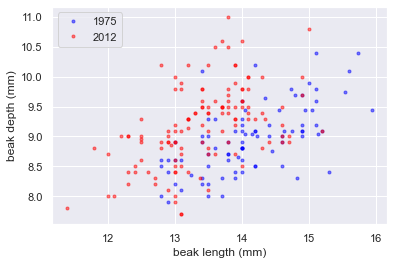

In [9]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975,bd_1975, color = 'blue', marker='.',
             linestyle='None', alpha=.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

#### Great work! In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

# Linear regressions
Perform a linear regression for both the 1975 and 2012 data. Then, perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line.

You will use the draw_bs_pairs_linreg() function you wrote back in chapter 2.

As a reminder, its call signature is draw_bs_pairs_linreg(x, y, size=1), and it returns bs_slope_reps and bs_intercept_reps. The beak length data are stored as bl_1975 and bl_2012, and the beak depth data is stored in bd_1975 and bd_2012.

Instructions
70 XP
Compute the slope and intercept for both the 1975 and 2012 data sets.
Obtain 1000 pairs bootstrap samples for the linear regressions using your draw_bs_pairs_linreg() function.
Compute 95% confidence intervals for the slopes and the intercepts.


Show Answer (-70 XP)
Hint
The slope and intercept for each of the datasets can be calculated using np.polyfit.
Use the draw_bs_pairs_linreg() function to obtain 1000 pairs bootstrap samples.
The 95% confidence intervals can be calculated by passing in [2.5, 97.5] as an argument along with the relevant slope and intercept to np.percentile.

In [10]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(
                            bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(
                            bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.34322939 0.59311125]
1975: intercept = 2.3908752365842263 conf int = [0.60537119 4.11152201]
2012: slope = 0.462630358835313 conf int = [0.33581448 0.59737005]
2012: intercept = 2.9772474982360198 conf int = [1.181177   4.67650119]


#    Displaying the linear regression results
Now, you will display your linear regression results on the scatter plot, the code for which is already pre-written for you from your previous exercise. To do this, take the first 100 bootstrap samples (stored in bs_slope_reps_1975, bs_intercept_reps_1975, bs_slope_reps_2012, and bs_intercept_reps_2012) and plot the lines with alpha=0.2 and linewidth=0.5 keyword arguments to plt.plot().

Instructions
100 XP
Generate the -values for the bootstrap lines using np.array(). They should consist of 10 mm and 17 mm.
Write a for loop to plot 100 of the bootstrap lines for the 1975 and 2012 data sets. The lines for the 1975 data set should be 'blue' and those for the 2012 data set should be 'red'.
Hit submit to view the plot!
To create an array of values consisting of 7 and 11, you could use np.array([7, 11]).
Recall that the linear equation is y = slope*x + intercept. The bootstrapped slopes are stored in the arrays bs_slope_reps_1975 and bs_slope_reps_2012. The bootstrapped intercepts are stored in the arrays bs_intercept_reps_1975 and bs_intercept_reps_2012. For each iteration inside your for loop, substitute the second argument inside plt.plot() with the linear regression equation with correct slopes and intercepts. Ensure that the lines for the 1975 data set are blue and those for the 2012 data set are red.

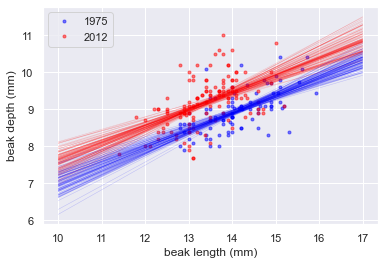

In [11]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

# Beak length to depth ratio
The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

Remember, the data are stored in bd_1975, bd_2012, bl_1975, and bl_2012.

Instructions
70 XP
Make arrays of the beak length to depth ratio of each bird for 1975 and for 2012.
Compute the mean of the length to depth ratio for 1975 and for 2012.
Generate 10,000 bootstrap replicates each for the mean ratio for 1975 and 2012 using your draw_bs_reps() function.
Get a 99% bootstrap confidence interval for the length to depth ratio for 1975 and 2012.
Print the results.


Show Answer (-70 XP)
Hint
Divide the beak length by the beak depth to calculate the length-to-depth ratios, first for 1975, and then for 2012. Thanks to NumPy's vectorized operations, this creates an array of the length to depth ratio for each year.
To obtain point estimates for the mean length to depth ratio for each year, use np.mean() on the arrays you calculated above (ratio_1975 and ratio_2012).
Use draw_bs_reps with np.mean as the func argument to generate 10000 bootstrap replicates for ratio_1975 and ratio_2012.
To get a 99% confidence interval, you need to pass in [0.5, 99.5] as an argument to np.percentile() along with the array containing the bootstrap replicates of the mean length-to-depth ratio for each year.

In [12]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)


1975: mean ratio = 1.5788823771858533 conf int = [1.55662508 1.5998226 ]
2012: mean ratio = 1.4658342276847767 conf int = [1.44435811 1.48822481]


# How different is the ratio?
In the previous exercise, you computed the mean beak length to depth ratio with 99% confidence intervals for 1975 and for 2012. The results of that calculation are shown graphically in the plot accompanying this problem. In addition to these results, what would you say about the ratio of beak length to depth?

Instructions
50 XP
Possible Answers

#### The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

# 1. Calculation of heritability
What is causing the beaks of Geospiza scandens to get bigger over time? I mentioned the selective pressure brought on by the drought. But why do some birds have such large beaks to begin with? A prevailing explanation is that scandens birds are mating the other major finch species on Daphne Major, Geopsiza fortis.

2. The finches of Daphne Major
These hybrid birds then mate with pure scandens, in a process called introgressive hybridization, which can bring fortis characteristics into the scandens species. This is similar to what likely happened to humans when they encountered neanderthals. In order assess the viability of this explanation,

1 Source: John Gould, public domain
3. Heredity
we need to know how strongly parental traits are passed on to offspring. In this last set of exercises, we will investigate the extent to which parental beak depth is inherited by offspring in both scandens and fortis. You are applying your new statistical skills to a real, fundamental scientific problem.

4. Let's practice!
I find this exhilarating, and I hope you do, too!

# EDA of heritability
The array bd_parent_scandens contains the average beak depth (in mm) of two parents of the species G. scandens. The array bd_offspring_scandens contains the average beak depth of the offspring of the respective parents. The arrays bd_parent_fortis and bd_offspring_fortis contain the same information about measurements from G. fortis birds.

Make a scatter plot of the average offspring beak depth (y-axis) versus average parental beak depth (x-axis) for both species. Use the alpha=0.5 keyword argument to help you see overlapping points.

Instructions
100 XP
Generate scatter plots for both species. Display the data for G. fortis in blue and G. scandens in red.
Set the axis labels, make a legend, and show the plot.

In [13]:
bd_parent_fortis = np.array([10.1  ,  9.55 ,  9.4  , 10.25 , 10.125,  9.7  ,  9.05 ,  7.4  ,9.   ,  8.65 ,  9.625,  9.9  ,  9.55 ,  9.05 ,  8.35 , 10.1  ,10.1  ,  9.9  , 10.225, 10.   , 10.55 , 10.45 ,  9.2  , 10.2  ,8.95 , 10.05 , 10.2  ,  9.5  ,  9.925,  9.95 , 10.05 ,  8.75 ,9.2  , 10.15 ,  9.8  , 10.7  , 10.5  ,  9.55 , 10.55 , 10.475,8.65 , 10.7  ,  9.1  ,  9.4  , 10.3  ,  9.65 ,  9.5  ,  9.7  ,10.525,  9.95 , 10.1  ,  9.75 , 10.05 ,  9.9  , 10.   ,  9.1  ,9.45 ,  9.25 ,  9.5  , 10.   , 10.525,  9.9  , 10.4  ,  8.95 ,9.4  , 10.95 , 10.75 , 10.1  ,  8.05 ,  9.1  ,  9.55 ,  9.05 ,10.2  , 10.   , 10.55 , 10.75 ,  8.175,  9.7  ,  8.8  , 10.75 ,9.3  ,  9.7  ,  9.6  ,  9.75 ,  9.6  , 10.45 , 11.   , 10.85 ,10.15 , 10.35 , 10.4  ,  9.95 ,  9.1  , 10.1  ,  9.85 ,  9.625,9.475,  9.   ,  9.25 ,  9.1  ,  9.25 ,  9.2  ,  9.95 ,  8.65 ,9.8  ,  9.4  ,  9.   ,  8.55 ,  8.75 ,  9.65 ,  8.95 ,  9.15 ,9.85 , 10.225,  9.825, 10.   ,  9.425, 10.4  ,  9.875,  8.95 ,8.9  ,  9.35 , 10.425, 10.   , 10.175,  9.875,  9.875,  9.15 ,9.45 ,  9.025,  9.7  ,  9.7  , 10.05 , 10.3  ,  9.6  , 10.   ,9.8  , 10.05 ,  8.75 , 10.55 ,  9.7  , 10.   ,  9.85 ,  9.8  ,9.175,  9.65 ,  9.55 ,  9.9  , 11.55 , 11.3  , 10.4  , 10.8  ,9.8  , 10.45 , 10.   , 10.75 ,  9.35 , 10.75 ,  9.175,  9.65 ,8.8  , 10.55 , 10.675,  9.95 ,  9.55 ,  8.825,  9.7  ,  9.85 ,9.8  ,  9.55 ,  9.275, 10.325,  9.15 ,  9.35 ,  9.15 ,  9.65 ,10.575,  9.975,  9.55 ,  9.2  ,  9.925,  9.2  ,  9.3  ,  8.775,9.325,  9.175,  9.325,  8.975,  9.7  ,  9.5  , 10.225, 10.025,8.2  ,  8.2  ,  9.55 ,  9.05 ,  9.6  ,  9.6  , 10.15 ,  9.875,10.485, 11.485, 10.985,  9.7  ,  9.65 ,  9.35 , 10.05 , 10.1  ,9.9  ,  8.95 ,  9.3  ,  9.95 ,  9.45 ,  9.5  ,  8.45 ,  8.8  ,8.525,  9.375, 10.2  ,  7.625,  8.375,  9.25 ,  9.4  , 10.55 ,8.9  ,  8.8  ,  9.   ,  8.575,  8.575,  9.6  ,  9.375,  9.6  ,9.95 ,  9.6  , 10.2  ,  9.85 ,  9.625,  9.025, 10.375, 10.25 ,9.3  ,  9.5  ,  9.55 ,  8.55 ,  9.05 ,  9.9  ,  9.8  ,  9.75 ,10.25 ,  9.1  ,  9.65 , 10.3  ,  8.9  ,  9.95 ,  9.5  ,  9.775,9.425,  7.75 ,  7.55 ,  9.1  ,  9.6  ,  9.575,  8.95 ,  9.65 ,9.65 ,  9.65 ,  9.525,  9.85 ,  9.05 ,  9.3  ,  8.9  ,  9.45 ,10.   ,  9.85 ,  9.25 , 10.1  ,  9.125,  9.65 ,  9.1  ,  8.05 ,7.4  ,  8.85 ,  9.075,  9.   ,  9.7  ,  8.7  ,  9.45 ,  9.7  ,8.35 ,  8.85 ,  9.7  ,  9.45 , 10.3  , 10.   , 10.45 ,  9.45 ,8.5  ,  8.3  , 10.   ,  9.225,  9.75 ,  9.15 ,  9.55 ,  9.   ,9.275,  9.35 ,  8.95 ,  9.875,  8.45 ,  8.6  ,  9.7  ,  8.55 ,9.05 ,  9.6  ,  8.65 ,  9.2  ,  8.95 ,  9.6  ,  9.15 ,  9.4  ,8.95 ,  9.95 , 10.55 ,  9.7  ,  8.85 ,  8.8  , 10.   ,  9.05 ,8.2  ,  8.1  ,  7.25 ,  8.3  ,  9.15 ,  8.6  ,  9.5  ,  8.05 ,9.425,  9.3  ,  9.8  ,  9.3  ,  9.85 ,  9.5  ,  8.65 ,  9.825,9.   , 10.45 ,  9.1  ,  9.55 ,  9.05 , 10.   ,  9.35 ,  8.375,8.3  ,  8.8  , 10.1  ,  9.5  ,  9.75 , 10.1  ,  9.575,  9.425,9.65 ,  8.725,  9.025,  8.5  ,  8.95 ,  9.3  ,  8.85 ,  8.95 ,9.8  ,  9.5  ,  8.65 ,  9.1  ,  9.4  ,  8.475,  9.35 ,  7.95 ,9.35 ,  8.575,  9.05 ,  8.175,  9.85 ,  7.85 ,  9.85 , 10.1  ,9.35 ,  8.85 ,  8.75 ,  9.625,  9.25 ,  9.55 , 10.325,  8.55 ,9.675,  9.15 ,  9.   ,  9.65 ,  8.6  ,  8.8  ,  9.   ,  9.95 ,8.4  ,  9.35 , 10.3  ,  9.05 ,  9.975,  9.975,  8.65 ,  8.725,8.2  ,  7.85 ,  8.775,  8.5  ,  9.4  ]) 
bd_offspring_fortis = np.array([10.7 ,  9.78,  9.48,  9.6 , 10.27,  9.5 ,  9.  ,  7.46,  7.65,8.63,  9.81,  9.4 ,  9.48,  8.75,  7.6 , 10.  , 10.09,  9.74,9.64,  8.49, 10.15, 10.28,  9.2 , 10.01,  9.03,  9.94, 10.5 ,9.7 , 10.02, 10.04,  9.43,  8.1 ,  9.5 ,  9.9 ,  9.48, 10.18,10.16,  9.08, 10.39,  9.9 ,  8.4 , 10.6 ,  8.75,  9.46,  9.6 ,9.6 ,  9.95, 10.05, 10.16, 10.1 ,  9.83,  9.46,  9.7 ,  9.82,10.34,  8.02,  9.65,  9.87,  9.  , 11.14,  9.25,  8.14, 10.23,8.7 ,  9.8 , 10.54, 11.19,  9.85,  8.1 ,  9.3 ,  9.34,  9.19,9.52,  9.36,  8.8 ,  8.6 ,  8.  ,  8.5 ,  8.3 , 10.38,  8.54,8.94, 10.  ,  9.76,  9.45,  9.89, 10.9 ,  9.91,  9.39,  9.86,9.74,  9.9 ,  9.09,  9.69, 10.24,  8.9 ,  9.67,  8.93,  9.3 ,8.67,  9.15,  9.23,  9.59,  9.03,  9.58,  8.97,  8.57,  8.47,8.71,  9.21,  9.13,  8.5 ,  9.58,  9.21,  9.6 ,  9.32,  8.7 ,10.46,  9.29,  9.24,  9.45,  9.35, 10.19,  9.91,  9.18,  9.89,9.6 , 10.3 ,  9.45,  8.79,  9.2 ,  8.8 ,  9.69, 10.61,  9.6 ,9.9 ,  9.26, 10.2 ,  8.79,  9.28,  8.83,  9.76, 10.2 ,  9.43,9.4 ,  9.9 ,  9.5 ,  8.95,  9.98,  9.72,  9.86, 11.1 ,  9.14,10.49,  9.75, 10.35,  9.73,  9.83,  8.69,  9.58,  8.42,  9.25,10.12,  9.31,  9.99,  8.59,  8.74,  8.79,  9.6 ,  9.52,  8.93,10.23,  9.35,  9.35,  9.09,  9.04,  9.75, 10.5 ,  9.09,  9.05,9.54,  9.3 ,  9.06,  8.7 ,  9.32,  8.4 ,  8.67,  8.6 ,  9.53,9.77,  9.65,  9.43,  8.35,  8.26,  9.5 ,  8.6 ,  9.57,  9.14,10.79,  8.91,  9.93, 10.7 ,  9.3 ,  9.93,  9.51,  9.44, 10.05,10.13,  9.24,  8.21,  8.9 ,  9.34,  8.77,  9.4 ,  8.82,  8.83,8.6 ,  9.5 , 10.2 ,  8.09,  9.07,  9.29,  9.1 , 10.19,  9.25,8.98,  9.02,  8.6 ,  8.25,  8.7 ,  9.9 ,  9.65,  9.45,  9.38,10.4 ,  9.96,  9.46,  8.26, 10.05,  8.92,  9.5 ,  9.43,  8.97,8.44,  8.92, 10.3 ,  8.4 ,  9.37,  9.91, 10.  ,  9.21,  9.95,8.84,  9.82,  9.5 , 10.29,  8.4 ,  8.31,  9.29,  8.86,  9.4 ,9.62,  8.62,  8.3 ,  9.8 ,  8.48,  9.61,  9.5 ,  9.37,  8.74,9.31,  9.5 ,  9.49,  9.74,  9.2 ,  9.24,  9.7 ,  9.64,  9.2 ,7.5 ,  7.5 ,  8.7 ,  8.31,  9.  ,  9.74,  9.31, 10.5 ,  9.3 ,8.12,  9.34,  9.72,  9.  ,  9.65,  9.9 , 10.  , 10.1 ,  8.  ,9.07,  9.75,  9.33,  8.11,  9.36,  9.74,  9.9 ,  9.23,  9.7 ,8.2 ,  9.35,  9.49,  9.34,  8.87,  9.03,  9.07,  9.43,  8.2 ,9.19,  9.  ,  9.2 ,  9.06,  9.81,  8.89,  9.4 , 10.45,  9.64,9.03,  8.71,  9.91,  8.33,  8.2 ,  7.83,  7.14,  8.91,  9.18,8.8 ,  9.9 ,  7.73,  9.25,  8.7 ,  9.5 ,  9.3 ,  9.05, 10.18,8.85,  9.24,  9.15,  9.98,  8.77,  9.8 ,  8.65, 10.  ,  8.81,8.01,  7.9 ,  9.41, 10.18,  9.55,  9.08,  8.4 ,  9.75,  8.9 ,9.07,  9.35,  8.9 ,  8.19,  8.65,  9.19,  8.9 ,  9.28, 10.58,9.  ,  9.4 ,  8.91,  9.93, 10.  ,  9.37,  7.4 ,  9.  ,  8.8 ,9.18,  8.3 , 10.08,  7.9 ,  9.96, 10.4 ,  9.65,  8.8 ,  8.65,9.7 ,  9.23,  9.43,  9.93,  8.47,  9.55,  9.28,  8.85,  8.9 ,8.75,  8.63,  9.  ,  9.43,  8.28,  9.23, 10.4 ,  9.  ,  9.8 ,9.77,  8.97,  8.37,  7.7 ,  7.9 ,  9.5 ,  8.2 ,  8.8 ])
bd_parent_scandens = np.array([ 8.3318,  8.4035,  8.5317,  8.7202,  8.7089,  8.7541,  8.773 ,8.8107,  8.7919,  8.8069,  8.6523,  8.6146,  8.6938,  8.7127,8.7466,  8.7504,  8.7805,  8.7428,  8.7164,  8.8032,  8.8258,8.856 ,  8.9012,  8.9125,  8.8635,  8.8258,  8.8522,  8.8974,8.9427,  8.9879,  8.9615,  8.9238,  8.9351,  9.0143,  9.0558,9.0596,  8.9917,  8.905 ,  8.9314,  8.9465,  8.9879,  8.9804,9.0219,  9.052 ,  9.0407,  9.0407,  8.9955,  8.9992,  8.9992,9.0747,  9.0747,  9.5385,  9.4781,  9.4517,  9.3537,  9.2707,9.1199,  9.1689,  9.1425,  9.135 ,  9.1011,  9.1727,  9.2217,9.2255,  9.2821,  9.3235,  9.3198,  9.3198,  9.3198,  9.3273,9.3725,  9.3989,  9.4253,  9.4593,  9.4442,  9.4291,  9.2632,9.2293,  9.1878,  9.1425,  9.1275,  9.1802,  9.1765,  9.2481,9.2481,  9.1991,  9.1689,  9.1765,  9.2406,  9.3198,  9.3235,9.1991,  9.2971,  9.2443,  9.316 ,  9.2934,  9.3914,  9.3989,9.5121,  9.6176,  9.5535,  9.4668,  9.3725,  9.3348,  9.3763,9.3839,  9.4216,  9.4065,  9.3348,  9.4442,  9.4367,  9.5083,9.448 ,  9.4781,  9.595 ,  9.6101,  9.5686,  9.6365,  9.7119,9.8213,  9.825 ,  9.7609,  9.6516,  9.5988,  9.546 ,  9.6516,9.7572,  9.8854, 10.0023,  9.3914])
bd_offspring_scandens = np.array([ 8.419 ,  9.2468,  8.1532,  8.0089,  8.2215,  8.3734,  8.5025,8.6392,  8.7684,  8.8139,  8.7911,  8.9051,  8.9203,  8.8747,8.943 ,  9.0038,  8.981 ,  9.0949,  9.2696,  9.1633,  9.1785,9.1937,  9.2772,  9.0722,  8.9658,  8.9658,  8.5025,  8.4949,8.4949,  8.5633,  8.6013,  8.6468,  8.1532,  8.3734,  8.662 ,8.6924,  8.7456,  8.8367,  8.8595,  8.9658,  8.9582,  8.8671,8.8671,  8.943 ,  9.0646,  9.1405,  9.2089,  9.2848,  9.3759,9.4899,  9.4519,  8.1228,  8.2595,  8.3127,  8.4949,  8.6013,8.4646,  8.5329,  8.7532,  8.8823,  9.0342,  8.6392,  8.6772,8.6316,  8.7532,  8.8291,  8.8975,  8.9734,  9.0494,  9.1253,9.1253,  9.1253,  9.1785,  9.2848,  9.4595,  9.3608,  9.2089,9.2544,  9.3684,  9.3684,  9.2316,  9.1709,  9.2316,  9.0342,8.8899,  8.8291,  8.981 ,  8.8975, 10.4089, 10.1886,  9.7633,9.7329,  9.6114,  9.5051,  9.5127,  9.3684,  9.6266,  9.5354,10.0215, 10.0215,  9.6266,  9.6038,  9.4063,  9.2316,  9.338 ,9.262 ,  9.262 ,  9.4063,  9.4367,  9.0342,  8.943 ,  8.9203,8.7835,  8.7835,  9.057 ,  8.9354,  8.8975,  8.8139,  8.8671,9.0873,  9.2848,  9.2392,  9.2924,  9.4063,  9.3152,  9.4899,9.5962,  9.6873,  9.5203,  9.6646])

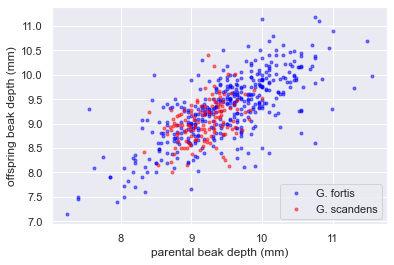

In [14]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()


#### It appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis. We'll quantify this correlation next.

# Correlation of offspring and parental data
In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

You have already written a function to do pairs bootstrap to get estimates for parameters derived from linear regression. Your task in this exercise is to make a new function with call signature draw_bs_pairs(x, y, func, size=1) that performs pairs bootstrap and computes a single statistic on pairs samples defined. The statistic of interest is computed by calling func(bs_x, bs_y). In the next exercise, you will use pearson_r for func.

Instructions
0 XP
Set up an array of indices to sample from. (Remember, when doing pairs bootstrap, we randomly choose indices and use those to get the pairs.)
Initialize the array of bootstrap replicates. This should be a one-dimensional array of length size.
Write a for loop to draw the samples.
Randomly choose indices from the array of indices you previously set up.
Extract x values and y values from the input array using the indices you just chose to generate a bootstrap sample.
Use func to compute the statistic of interest from the bootstrap samples of x and y and store it in your array of bootstrap replicates.
Return the array of bootstrap replicates.

Hint
To set up the array of indices to sample from, use np.arange() with len(x), and then to initialize the empty array, use np.empty() with argument size. Store it in bs_replicates.
Inside the for loop, randomly generate indices with np.random.choice, where inds and len(inds) are the two arguments. Index x and y with these new indices and assign the result to bs_x and bs_y: These will be the arguments you pass into func, and the result of func should be stored in the bs_replicates array you initialized earlier!
bs_slope_reps and bs_intercept_reps are not necessary here. Instead, you only need to return bs_replicates.

In [15]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

# Pearson correlation of offspring and parental data
The Pearson correlation coefficient seems like a useful measure of how strongly the beak depth of parents are inherited by their offspring. Compute the Pearson correlation coefficient between parental and offspring beak depths for G. scandens. Do the same for G. fortis. Then, use the function you wrote in the last exercise to compute a 95% confidence interval using pairs bootstrap.

Remember, the data are stored in bd_parent_scandens, bd_offspring_scandens, bd_parent_fortis, and bd_offspring_fortis.

Instructions
100 XP
Use the pearson_r() function you wrote in the prequel to this course to compute the Pearson correlation coefficient for G. scandens and G. fortis.
Acquire 1000 pairs bootstrap replicates of the Pearson correlation coefficient using the draw_bs_pairs() function you wrote in the previous exercise for G. scandens and G. fortis.
Compute the 95% confidence interval for both using your bootstrap replicates.

You can compute the Pearson correlation coefficient with pearson_r().
You can use the draw_bs_pairs() with pearson_r as the func argument to acquire 1000 pairs boostrap replicates of the Pearson correlation coefficient.
As you have done in earlier exercises, use np.percentile() to calculate the 95% confidence interval. Recall that you have to pass in the 2.5 and 97.5 in the form of a list as an argument in addition to the array of bootstrap replicates.

In [16]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, pearson_r, size=1000)
bs_replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, pearson_r, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)


G. scandens: 0.4117063629401258 [0.27899969 0.5442159 ]
G. fortis: 0.7283412395518486 [0.67128853 0.78002163]


# Measuring heritability
Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

This exercise highlights a very important point. Statistical inference (and data analysis in general) is not a plug-n-chug enterprise. You need to think carefully about the questions you are seeking to answer with your data and analyze them appropriately. If you are interested in how heritable traits are, the quantity we defined as the heritability is more apt than the off-the-shelf statistic, the Pearson correlation coefficient.

Remember, the data are stored in bd_parent_scandens, bd_offspring_scandens, bd_parent_fortis, and bd_offspring_fortis.

Instructions
100 XP
Write a function heritability(parents, offspring) that computes heritability defined as the ratio of the covariance of the trait in parents and offspring divided by the variance of the trait in the parents. Hint: Remind yourself of the np.cov() function we covered in the prequel to this course.
Use this function to compute the heritability for G. scandens and G. fortis.
Acquire 1000 bootstrap replicates of the heritability using pairs bootstrap for G. scandens and G. fortis.
Compute the 95% confidence interval for both using your bootstrap replicates.
Print the results.

In [17]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens,
                                     bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis,
                                   bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685982 [0.35191885 0.7750083 ]
G. fortis: 0.7229051911438155 [0.64298246 0.79640658]


# Is beak depth heritable at all in G. scandens?
The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, you will do a pairs permutation test.

Instructions
100 XP
Initialize your array of replicates of heritability. We will take 10,000 pairs permutation replicates.
Write a for loop to generate your replicates.
Permute the bd_parent_scandens array using np.random.permutation().
Compute the heritability between the permuted array and the bd_offspring_scandens array using the heritability() function you wrote in the last exercise. Store the result in the replicates array.
Compute the p-value as the number of replicates that are greater than the observed heritability_scandens you computed in the last exercise.

You can use np.empty() to initialize your array that will store 10,000 pairs permutation replicates.
Inside the for loop, use np.random.permutation to permute bd_parent_scandens, and then compute the heritability between the permuted bd_parent_scandens and bd_offspring_scandens. For each iteration of the loop, store this heritability in the array you initialized earlier (perm_replicates).
You can compute the p-value by calculating the fraction of perm_replicates that are greater than or equal to the observed heritability_scandens you computed in the previous exercise.

In [18]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)


p-val = 0.0


1. Final thoughts
Wow, that finch beak analysis was intense. It makes me happy to know that you got to dive into one of my favorite data sets of all time. I hope going through that case study showed you how powerful you now are with your new skills in

2. Your statistical thinking skills
statistical inference, along with being able to implement them in Python. You can now do effective exploratory data analysis, plotting ECDFs and computing summary statistics. You can obtain parameters by optimization, including by linear regression. You can think probabilistically about those parameter values and give them confidence intervals. To do this, you can use the exceptionally powerful and versatile bootstrap method. Finally, you can formulate and test statistical hypotheses. There is a world of data out there for you to make inferences about using your hard-earnt Python skills! You have the knowledge and skills to do so. You are now a more powerful data scientist.

3. Let's practice!
Bon voyage!